# Story Generation
We remember things better as stories. The plan here is to pick a subset of our phrases, extract the vocabularly, and generate a story based off of them. We can then pull in more flashcards / phrases to ensure a more complete phrase coverage.

The story name will be story_some_title; when added as a 'tag' into Anki, this will add a hyperlink to a google cloud bucket of a specific format of bucket/language/story_name/story_name.html

This means it is easy to add new stories to an existing flashcard deck, and the links will update as soon as you add the tags

In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv

load_dotenv()

PAY_FOR_API = True #change to True to run cells that cost money via API calls

In [2]:
import random
from pathlib import Path
from pprint import pprint

from src.anki_tools import AnkiCollectionReader, get_deck_contents
from src.config_loader import config
from src.nlp import (
    create_flashcard_index,
    find_missing_vocabulary,
    get_vocab_dict_from_dialogue,
    get_vocab_dictionary_from_phrases,
)
from src.utils import (
    load_json,
    load_text_file,
    save_json,
    save_pickle,
    load_pickle,
    upload_story_to_gcs,
    upload_to_gcs,
)
# Add the parent directory of 'src' to the Python path


setting voice override: sv-SE-Wavenet-F
setting voice override: sv-SE-Wavenet-G
FFmpeg path added to system PATH: C:\Program Files\ffmpeg-7.0-essentials_build\bin


### Add directories
story images can be re-used between languages, but audio files are language specific, so we structure the story directory story_name/language with audio files in 'language/' and images and the english JSON file in story_name dir

In [3]:
notebook_dir = Path().absolute()  # This gives src/notebooks
phrase_dir = notebook_dir.parent / "data" / "phrases" #where we store text files of phrases
story_dir = notebook_dir.parent / "outputs" / "stories" # where we store our stories

we already have flashcards generated for some phrases:
a flashcard index allows us to select flashcards that cover a specific vocabulary range, it's quite computationally expensive, but is generated
using create_flashcard_index

In [4]:
PHRASE_LIST_NAME = "longman_1000_phrases"
phrase_file = phrase_dir / f"{PHRASE_LIST_NAME}.txt"
phrases = load_text_file(phrase_file)
pprint(f"First few phrases {phrases[:10]}")



("First few phrases ['Do you want to become a famous writer?', 'Let me show "
 "you around the city', 'We need to handle this situation carefully', 'Stop "
 'wasting time on this\', \'Do you like playing the guitar at night?\', "I\'m '
 'taking a vacation next month", "Don\'t forget to wear a helmet while '
 'cycling", "Let\'s cut unnecessary expenses this year", "We\'re producing a '
 'new product soon", \'Did you remember to turn off the stove?\']')


## create the flashcard index
This makes it very fast to find matching flashcards from a given vocab list

In [5]:
# long process, so only create if it doesn't exist
notebook_dir = Path().absolute()  # This gives src/notebooks
index_file = phrase_dir / f"{PHRASE_LIST_NAME}_index.json"

if index_file.exists():
    phrase_index = load_json(index_file)
else:
    phrase_index = create_flashcard_index(phrases)
    save_json(data=phrase_index, file_path=index_file)



## Sample some phrases to generate the story from
This will pin the story to the vocab found in some pre-existing phrases

In [6]:
#we can obtain phrases we know to create a story from:
# NOTE: you must close Anki Desktop when trying to form a connection here
with AnkiCollectionReader() as reader:
    pprint(reader.get_deck_names())

#this will print out deck_id : deck_name -> we want to copy the relevant deck_name

{1: 'Default',
 1731524665442: 'Swedish EAL',
 1732020971325: 'RapidRetention - Swedish - LM1000',
 1732316149591: 'RapidRetention - Russian - LM1000',
 1732316936163: 'RapidRetention - Italian - LM1000',
 1732637740663: 'RapidRetention - Welsh - LM1000',
 1732980361514: 'RapidRetention - Russian - GCSE',
 1732993700879: 'Persian Alphabet',
 1734260227418: 'RapidRetention - Swedish - NumbersDays',
 1734261644938: 'RapidRetention - Russian - NumbersDays',
 1734264578929: 'RapidRetention - Italian - NumbersDays',
 1734426251278: 'RapidRetention - French - NumbersDays',
 1735660105659: 'RapidRetention - Swedish - EatingOut',
 1735684325990: 'RapidRetention - Czech - EatingOut',
 1735687489606: 'RapidRetention - Welsh - EatingOut',
 1735998451053: 'RapidRetention - Italian - EatingOut',
 1737410923009: 'RapidRetention - Swedish - LanguageMeetUp'}


In [7]:
DECK_NAME = "RapidRetention - Swedish - LM1000"
df = get_deck_contents(deck_name=DECK_NAME) #calculates knowledge score
df.head()

,note_id,model_name,tags,n_cards,avg_ease,total_reps,avg_reps,total_lapses,avg_lapses,avg_interval,TargetText,TargetAudio,TargetAudioSlow,EnglishText,WiktionaryLinks,Picture,TargetLanguageName,knowledge_score
0,1732020511348,Language Practice With Images,,3,88.3,5,1.7,0,0.0,16.0,Var mer uppmärksam på detaljer,[sound:a821f020-5a84-44fb-af42-c6c4133e4379.mp3],[sound:3d6997c2-92c7-43c9-b31e-a20cc4f0bf9e.mp3],Pay more attention to details,"<a href=""https://en.wiktionary.org/wiki/var#Sw...","<img src=""f7153993-cfee-40f4-841c-1bd6cfaeb5a9...",Swedish,0.328
1,1732020511352,Language Practice With Images,,3,270.0,13,4.3,0,0.0,51.3,Kommer kunden att känna igen mig?,[sound:fa15b936-ef4e-44d5-932d-e94a6b477c9d.mp3],[sound:79a26555-55ef-43d6-a9ca-6ee02ade7721.mp3],Will the customer recognize me?,"<a href=""https://en.wiktionary.org/wiki/kommer...","<img src=""cd5e83e4-813e-4097-962a-cf536f866e99...",Swedish,0.369
2,1732020511356,Language Practice With Images,story_birthday_party_planning_mishap story_job...,3,83.3,5,1.7,0,0.0,24.0,Vänligen svara ärligt på alla frågor,[sound:f54483fc-3303-427d-acef-6710ae244bc9.mp3],[sound:41c55da5-347a-4d0b-b6c8-40b27b46c1b9.mp3],Please answer all questions honestly,"<a href=""https://en.wiktionary.org/wiki/v%C3%A...","<img src=""1a6640ec-fe2d-4808-b638-33a38b694224...",Swedish,0.342
3,1732020511360,Language Practice With Images,,3,88.3,2,0.7,0,0.0,6.3,Sluta slösa tid på detta,[sound:b34a331b-6dd9-44a2-a588-f92be1b11d06.mp3],[sound:a1a6714c-9bfd-4cd7-b30e-1a209c0ab42b.mp3],Stop wasting time on this,"<a href=""https://en.wiktionary.org/wiki/sluta#...","<img src=""8de5a6d3-b10c-45ea-860c-512cc2673be7...",Swedish,0.317
4,1732020511364,Language Practice With Images,,3,260.0,11,3.7,0,0.0,50.0,Vi producerar en ny produkt snart,[sound:10281f18-fddc-4a69-ab7b-6098f63b948f.mp3],[sound:0e472f07-e35b-4ab0-9161-e0a1474c6e34.mp3],We're producing a new product soon,"<a href=""https://en.wiktionary.org/wiki/vi#Swe...","<img src=""329bfcb3-7cb4-4174-923f-567a1bfe7ec9...",Swedish,0.370


Find phrases we know, and limit the flashcard index to those

In [8]:
from src.phrase import get_phrase_indices

known_phrases = df.query("knowledge_score > 0.2").sort_values(by="knowledge_score", ascending=False)['EnglishText'].tolist()

#we need to know the location of each phrase as an integer in the phrase_index
known_phrase_indicies = get_phrase_indices(known_phrases = known_phrases, all_phrases = phrase_index['phrases'])

In [9]:
from copy import deepcopy
from src.nlp import remove_unknown_index_values

#if we don't know a phrase, we don't want to retrieve that from the index and link it to a story
known_index = deepcopy(phrase_index)
known_index['verb_index'] = remove_unknown_index_values(known_phrase_indicies, known_index['verb_index'])
known_index['vocab_index'] = remove_unknown_index_values(known_phrase_indicies, known_index['vocab_index'])

In [10]:
sampled_phrases = random.sample(known_phrases, min(75, len(known_phrases)))


In [12]:
#or use sampled_phrases
vocab_dict_flashcards = get_vocab_dictionary_from_phrases(sampled_phrases) #75 phrases should give a decent amount of vocab

Now generate the story

In [13]:
from src.dialogue_generation import generate_story

story_name, story_dialogue = generate_story(vocab_dict_flashcards)


Function that called this one: generate_story. Sleeping for 20 seconds
generated story: Camping Trip Gone Awry


In [14]:
#story_name = "lost_in_stockholm"
clean_story_name = f"story_{story_name.lower().replace(' ', '_')}"
story_path = story_dir / clean_story_name / f"{clean_story_name}.json"

save_json(story_dialogue, story_path)
print(f"saved story to {story_path}")

saved story to y:\Python Scripts\audio-language-trainer\outputs\stories\story_camping_trip_gone_awry\story_camping_trip_gone_awry.json


We find that the LLM goes a bit beyond the vocab found in the flashcards

In [15]:
vocab_dict_story = get_vocab_dict_from_dialogue(story_dialogue, limit_story_parts=None)
vocab_overlap = find_missing_vocabulary(vocab_dict_flashcards, vocab_dict_story)

=== VOCABULARY COVERAGE ANALYSIS ===
Target verbs covered by flashcards: 56.8%
Target vocabulary covered by flashcards: 47.8%

Verbs needing new flashcards:
['grab', 'turn', 'could', "'ve", 'tell'] ...

Vocabulary needing new flashcards:
['thank', 'portable', 'hey', 'though', 'sometimes'] ...


Let's retrieve flashcards we know that better fit the story vocab

In [16]:
from src.nlp import get_matching_flashcards_indexed

# Let's pull all the existing phrases we need to cover the vocab on our story
#remember we modified the index to only use flashcards we know
known_results = get_matching_flashcards_indexed(vocab_dict_story, known_index)
known_flashcards = [card.get('phrase') for card in known_results['selected_cards']]
print("Average knowledge: ", df.loc[df['EnglishText'].isin(known_flashcards)].knowledge_score.mean())
known_vocab_dict = get_vocab_dictionary_from_phrases(known_flashcards)
missing_vocab = find_missing_vocabulary(vocab_dict_source=known_vocab_dict, vocab_dict_target=vocab_dict_story)
missing_vocab_dict = missing_vocab["missing_vocab"]


Average knowledge:  0.37
=== VOCABULARY COVERAGE ANALYSIS ===
Target verbs covered by flashcards: 81.1%
Target vocabulary covered by flashcards: 69.0%

Verbs needing new flashcards:
['grab', 'sleep', 'wake', 'heat', 'pack'] ...

Vocabulary needing new flashcards:
['portable', 'hey', 'though', 'definitely', 'actually'] ...


Now supplement these with any remaining flascards we don't yet know

In [17]:
#we should have a higher match in the cell above, we can now draw missing flashcards from the full index

additional_results = get_matching_flashcards_indexed(missing_vocab_dict, phrase_index)
additional_flashcards = [card.get('phrase') for card in additional_results['selected_cards']]
print(len(additional_flashcards))

all_flashcards = additional_flashcards + known_flashcards
all_flashcards_vocab_dict = get_vocab_dictionary_from_phrases(all_flashcards)
final_missing_vocab = find_missing_vocabulary(all_flashcards_vocab_dict, vocab_dict_story)


13
=== VOCABULARY COVERAGE ANALYSIS ===
Target verbs covered by flashcards: 86.5%
Target vocabulary covered by flashcards: 78.8%

Verbs needing new flashcards:
['grab', 'heat', 'pack', 'soak', 'pour'] 

Vocabulary needing new flashcards:
['portable', 'hey', 'though', 'fun', 'multiple'] ...


In [18]:
print(f"We need {len(all_flashcards)} flashcards to cover the story")

We need 62 flashcards to cover the story


## Generate the story files
Once you are happy with the flashcard coverage, you can:
* translate and add audio
* create the story images
* create the story album files (M4a files with synced lyrics)
* create the story HTML file using those previous files, and upload to Google Cloud Storage
* tag the flascards with the story name...this will then mean you can link to the story from within Anki (the template uses tags to auto-create hyperlinks)

In [19]:
from src.generate import add_audio, add_translations

story_dialogue_audio = add_translations(story_dialogue)
story_dialogue_audio = add_audio(story_dialogue_audio)

adding translations:   0%|          | 0/3 [00:00<?, ?it/s]

Beginning translation for introduction


adding translations:  33%|███▎      | 1/3 [00:02<00:04,  2.12s/it]

Translated dialogue
Beginning translation for development


adding translations:  67%|██████▋   | 2/3 [00:04<00:02,  2.00s/it]

Translated dialogue
Beginning translation for resolution


adding translations: 100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Translated dialogue


adding audio:   0%|          | 0/3 [00:00<?, ?it/s]

Beginning text-to-speech for introduction


adding audio:  33%|███▎      | 1/3 [00:41<01:22, 41.14s/it]

Text-to-speech for dialogue done
Beginning text-to-speech for development


adding audio:  67%|██████▋   | 2/3 [01:00<00:28, 28.32s/it]

Text-to-speech for dialogue done
Beginning text-to-speech for resolution


adding audio: 100%|██████████| 3/3 [01:20<00:00, 26.83s/it]

Text-to-speech for dialogue done


In [20]:
#this has target language content in now so we save in language dir
save_pickle(data=story_dialogue_audio, file_path=story_dir / clean_story_name / config.TARGET_LANGUAGE_NAME / f"{clean_story_name}.pkl")
#story_dialogue_audio = load_pickle(story_dir / clean_story_name / config.TARGET_LANGUAGE_NAME / f"{clean_story_name}.pkl")

Image files for each part of the story:

In [21]:
from src.images import generate_and_save_story_images
    
image_data = generate_and_save_story_images(story_dict=story_dialogue_audio, output_dir = story_dir / clean_story_name, story_name=clean_story_name)


Generating story images:   0%|          | 0/3 [00:00<?, ?it/s]

Function that called this one: create_image_generation_prompt_for_story_part. Sleeping for 20 seconds


Generating story images:  33%|███▎      | 1/3 [00:52<01:44, 52.39s/it]

Generated image with imagen using prompt: View from inside a cozy living room, late afternoon sunlight streaming through windows, camping gear and supplies scattered about, backpacks half-packed on the floor, a large tent box visible in the corner, and a warm, excited atmosphere conveyed through the golden light and disarray of preparations in the style of Studio Ghibli art style, soft atmospheric colors, detailed backgrounds, gentle gradients, natural elements, dreamy lighting, painted textures
Successfully generated and saved image for introduction


Waiting for API cooldown: 100%|██████████████| 6/6 [00:06<00:00,  1.02s/it]


Function that called this one: create_image_generation_prompt_for_story_part. Sleeping for 20 seconds


Generating story images:  67%|██████▋   | 2/3 [01:49<00:55, 55.43s/it]

Generated image with imagen using prompt: View through rain-streaked eyes of a dark, forested path leading to a rocky cave entrance, heavy rainfall obscuring distant trees and creating puddles, early morning gloom casting everything in muted tones and shadows in the style of Studio Ghibli art style, soft atmospheric colors, detailed backgrounds, gentle gradients, natural elements, dreamy lighting, painted textures
Successfully generated and saved image for development


Waiting for API cooldown: 100%|██████████████| 8/8 [00:08<00:00,  1.01s/it]


Function that called this one: create_image_generation_prompt_for_story_part. Sleeping for 20 seconds


Generating story images: 100%|██████████| 3/3 [02:48<00:00, 56.25s/it]

Generated image with imagen using prompt: Inside a dimly lit cave with a cozy campfire glow, looking out at heavy rain falling beyond the entrance, a small portable stove and camping gear visible in the foreground, creating an atmosphere of unexpected adventure and comfort amidst nature's elements in the style of Studio Ghibli art style, soft atmospheric colors, detailed backgrounds, gentle gradients, natural elements, dreamy lighting, painted textures
Successfully generated and saved image for resolution


M4A audio files which you will be able to download and play via a media player.
They have synced lyrics which can be viewed in the Oto Music Player app

In [22]:
from PIL import Image
from src.story import create_album_files, generate_index_html

FIRST_STORY_PART = list(image_data.keys())[0]
#may need to change depending on size of story made and what parts there are
album_image = Image.open(story_dir / clean_story_name / f"{clean_story_name}_{FIRST_STORY_PART}.png")
#create m4a file:
create_album_files(story_data_dict=story_dialogue_audio, cover_image=album_image, output_dir=story_dir / clean_story_name / config.TARGET_LANGUAGE_NAME, story_name=clean_story_name)

creating album:  33%|███▎      | 1/3 [00:03<00:06,  3.25s/it]

Saved M4A file track number 1


creating album:  67%|██████▋   | 2/3 [00:06<00:03,  3.35s/it]

Saved M4A file track number 2


creating album: 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

Saved M4A file track number 3


Now we generate the main html file - this wraps up the M4A files and image files within it, so it's self-contained

In [23]:
from src.story import create_html_story

create_html_story(
            story_data_dict=story_dialogue_audio,
            image_dir=story_dir / clean_story_name, #the langauge sub-folders will be picked up automatically
            story_name=clean_story_name,
        )

Preparing HTML data: 100%|██████████| 3/3 [02:06<00:00, 42.01s/it]


HTML story created at: y:\Python Scripts\audio-language-trainer\outputs\stories\story_camping_trip_gone_awry\Swedish\story_camping_trip_gone_awry.html


Upload to a public google cloud bucket

In [24]:
html_story_path = story_dir / clean_story_name / config.TARGET_LANGUAGE_NAME / f"{clean_story_name}.html"
assert html_story_path.exists()
upload_story_to_gcs(html_file_path=html_story_path)

'https://storage.googleapis.com/audio-language-trainer-stories/swedish/story_camping_trip_gone_awry/story_camping_trip_gone_awry.html'

Now update and reupload our index.html - which allows users to navigate all the stories

In [25]:
generate_index_html()
#will default to public GCS bucket
upload_to_gcs(
    file_path="../outputs/stories/index.html",
    content_type="text/html"
)


'https://storage.googleapis.com/audio-language-trainer-stories/index.html'

## Linking stories to flash cards
We will use the Anki tag feature. Given a list of english phrases that are required to understand a story, we can tag each of those phrases within a specific Anki Deck.

The card template will turn any tag starting story_ into a hyperlink to the public google cloud bucket

In [29]:
#sometimes this needs running twice...
from src.anki_tools import add_tag_to_matching_notes

updates, errors = add_tag_to_matching_notes(
    deck_name=DECK_NAME,
    phrases=all_flashcards,
    tag=clean_story_name
)

print(f"Updated {updates} notes")
if errors:
    print("Errors encountered:")
    for error in errors:
        print(f"- {error}")

audio-language-trainer\src\anki_tools.py:217:save() is deprecated: saving is automatic
Updated 62 notes


In [27]:
df_deck = get_deck_contents(DECK_NAME)
df_deck.query("tags == @clean_story_name").shape

(29, 18)

<Axes: >

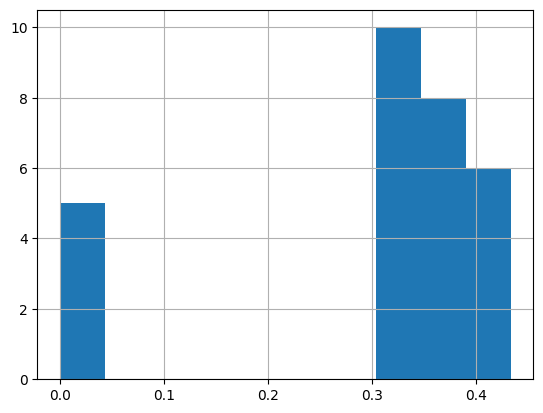

In [28]:
#we should know most of the vocab...
df_deck.query("tags == @clean_story_name").knowledge_score.hist()